In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set(style="darkgrid", font_scale=0.8)
sns.set(rc={"figure.figsize": (16, 5)})
pd.options.display.max_rows = None
pd.options.display.max_colwidth = None

path = Path().parent.absolute()
bike_path = path / "Fahrraddiebstahl.csv"
lor_path = path / "lor_ortsteile.csv"


In [2]:
bike_dtypes = {
    "ANGELEGT_AM": "object",
    "TATZEIT_ANFANG_DATUM": "object",
    "TATZEIT_ANFANG_STUNDE": "int64",
    "TATZEIT_ENDE_DATUM": "object",
    "TATZEIT_ENDE_STUNDE": "int64",
    "LOR": "object",
    "SCHADENSHOEHE": "int64",
    "VERSUCH": "object",
    "ART_DES_FAHRRADS": "object",
    "DELIKT": "object",
    "ERFASSUNGSGRUND": "object",
}

lor_dtypes = {
    "spatial_name": "object",
    "OTEIL": "object",
    "BEZIRK": "object",
    "FLAECHE_HA": "float64",
}


In [3]:
with open(bike_path, "rb") as file:
    bike_data = pd.read_csv(file, encoding="latin1", dtype=bike_dtypes)

with open(lor_path, "rb") as file:
    lor_data = pd.read_csv(
        file,
        encoding="utf-8",
        dtype=lor_dtypes,
        usecols=["spatial_name", "OTEIL", "BEZIRK", "FLAECHE_HA"],
    )


In [4]:
# bike_data.info()
# lor_data.info()


In [5]:
# Aufbereitung von timevalues
bike_data["ANGELEGT_AM"] = pd.to_datetime(bike_data["ANGELEGT_AM"], dayfirst=True)
bike_data["TATZEIT_ANFANG_DATUM"] = pd.to_datetime(
    bike_data["TATZEIT_ANFANG_DATUM"], dayfirst=True
) + pd.to_timedelta(bike_data.TATZEIT_ANFANG_STUNDE, unit="h")
bike_data["TATZEIT_ENDE_DATUM"] = pd.to_datetime(
    bike_data["TATZEIT_ENDE_DATUM"], dayfirst=True
) + pd.to_timedelta(bike_data.TATZEIT_ENDE_STUNDE, unit="h")
bike_data["TATDAUER_STUNDEN"] = (
    bike_data.TATZEIT_ENDE_DATUM - bike_data.TATZEIT_ANFANG_DATUM
).astype("timedelta64[h]")

# Vorbereitung eines keys zum Join mit Bezirksübersichtstabelle
bike_data["BEZ"] = bike_data["LOR"].str[0:2] + bike_data["LOR"].str[4:6]
lor_data = lor_data.rename(columns={"spatial_name": "BEZ"})


In [6]:
bike_data.head()


,ANGELEGT_AM,TATZEIT_ANFANG_DATUM,TATZEIT_ANFANG_STUNDE,TATZEIT_ENDE_DATUM,TATZEIT_ENDE_STUNDE,LOR,SCHADENSHOEHE,VERSUCH,ART_DES_FAHRRADS,DELIKT,ERFASSUNGSGRUND,TATDAUER_STUNDEN,BEZ
0,2023-02-19,2023-02-18 18:00:00,18,2023-02-19 07:00:00,7,03701658,3472,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,13.0,0316
1,2023-02-19,2023-02-18 20:00:00,20,2023-02-19 09:00:00,9,01100308,2277,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,13.0,0103
2,2023-02-19,2023-02-18 16:00:00,16,2023-02-19 00:00:00,0,06100102,746,Nein,Damenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,8.0,0601
3,2023-02-19,2023-02-18 17:00:00,17,2023-02-19 00:00:00,0,07601544,1849,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,7.0,0715
4,2023-02-19,2023-02-17 17:00:00,17,2023-02-17 17:00:00,17,03601346,1863,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,0.0,0313


In [7]:
merged_df = bike_data.merge(lor_data, how="left", on="BEZ")
merged_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 24610 entries, 0 to 24609
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ANGELEGT_AM            24610 non-null  datetime64[ns]
 1   TATZEIT_ANFANG_DATUM   24610 non-null  datetime64[ns]
 2   TATZEIT_ANFANG_STUNDE  24610 non-null  int64         
 3   TATZEIT_ENDE_DATUM     24610 non-null  datetime64[ns]
 4   TATZEIT_ENDE_STUNDE    24610 non-null  int64         
 5   LOR                    24610 non-null  object        
 6   SCHADENSHOEHE          24610 non-null  int64         
 7   VERSUCH                24610 non-null  object        
 8   ART_DES_FAHRRADS       24610 non-null  object        
 9   DELIKT                 24610 non-null  object        
 10  ERFASSUNGSGRUND        24610 non-null  object        
 11  TATDAUER_STUNDEN       24610 non-null  float64       
 12  BEZ                    24610 non-null  object        
 13  O

In [8]:
# merged_df.columns.to_list()
for col in merged_df[
    [
        "VERSUCH",
        "ART_DES_FAHRRADS",
        "DELIKT",
        "ERFASSUNGSGRUND",
        "BEZIRK",
    ]
]:
    print(f"{col} : \n {merged_df[col].unique()}")


VERSUCH : 
 ['Nein' 'Unbekannt' 'Ja']
ART_DES_FAHRRADS : 
 ['Herrenfahrrad' 'Damenfahrrad' 'Mountainbike' 'diverse Fahrräder'
 'Fahrrad' 'Kinderfahrrad' 'Rennrad' 'Lastenfahrrad']
DELIKT : 
 ['Fahrraddiebstahl' 'Keller- und Bodeneinbruch']
ERFASSUNGSGRUND : 
 ['Sonstiger schwerer Diebstahl von Fahrrädern'
 'Einfacher Diebstahl von Fahrrädern'
 'Sonstiger schwerer Diebstahl in/aus Keller/Boden von Fahrrädern'
 'Einfacher Diebstahl aus Keller/Boden von Fahrrädern']
BEZIRK : 
 [nan 'Mitte' 'Steglitz-Zehlendorf' 'Pankow' 'Spandau'
 'Friedrichshain-Kreuzberg' 'Neukölln' 'Reinickendorf' 'Treptow-Köpenick'
 'Charlottenburg-Wilmersdorf' 'Tempelhof-Schöneberg' 'Lichtenberg'
 'Marzahn-Hellersdorf']


## Auswertung

Pro Bezirk:
- Was sind die totals der Delikte?
- Was sind die minima/maxima der Daten?

In [ ]:
merged_df.groupby(["BEZIRK"], dropna=False).agg(
    {
        "ANGELEGT_AM": ["count", "min", "max"],
        "TATZEIT_ANFANG_DATUM": ["min", "max"],
        "TATZEIT_ENDE_DATUM": ["min", "max"],
    }
).sort_values(by=("ANGELEGT_AM", "count"), ascending=False)


ANGELEGT_AM                        \
                                 count        min        max   
BEZIRK                                                         
NaN                               8343 2022-01-01 2023-02-19   
Pankow                            2635 2022-01-01 2023-02-19   
Mitte                             2345 2022-01-02 2023-02-19   
Neukölln                          1599 2022-01-03 2023-02-19   
Tempelhof-Schöneberg              1511 2022-01-02 2023-02-19   
Friedrichshain-Kreuzberg          1388 2022-01-01 2023-02-19   
Treptow-Köpenick                  1305 2022-01-04 2023-02-19   
Charlottenburg-Wilmersdorf        1293 2022-01-03 2023-02-19   
Steglitz-Zehlendorf               1216 2022-01-03 2023-02-19   
Lichtenberg                       1008 2022-01-03 2023-02-18   
Reinickendorf                      872 2022-01-03 2023-02-19   
Spandau                            727 2022-01-07 2023-02-19   
Marzahn-Hellersdorf                368 2022-01-04 2023-02-18   

                           TATZEIT_ANFANG_DATUM                      \
                                            min                 max   
BEZIRK                                                                
NaN                         2022-01-01 09:00:00 2023-02-19 11:00:00   
Pankow                      2022-01-01 02:00:00 2023-02-19 11:00:00   
Mitte                       2022-01-01 00:00:00 2023-02-19 04:00:00   
Neukölln                    2022-01-01 12:00:00 2023-02-17 12:00:00   
Tempelhof-Schöneberg        2022-01-01 00:00:00 2023-02-17 20:00:00   
Friedrichshain-Kreuzberg    2022-01-01 04:00:00 2023-02-19 18:00:00   
Treptow-Köpenick            2022-01-01 08:00:00 2023-02-18 16:00:00   
Charlottenburg-Wilmersdorf  2022-01-02 07:00:00 2023-02-18 17:00:00   
Steglitz-Zehlendorf         2022-01-02 09:00:00 2023-02-18 16:00:00   
Lichtenberg                 2022-01-02 11:00:00 2023-02-17 07:00:00   
Reinickendorf               2022-01-02 17:00:00 2023-02-18 12:00:00   
Spandau                     2022-01-05 03:00:00 2023-02-18 23:00:00   
Marzahn-Hellersdorf         2022-01-03 18:00:00 2023-02-15 18:00:00   

                            TATZEIT_ENDE_DATUM                      
                                           min                 max  
BEZIRK                                                              
NaN                        2022-01-01 09:00:00 2023-02-19 11:00:00  
Pankow                     2022-01-01 14:00:00 2023-02-19 21:00:00  
Mitte                      2022-01-01 00:00:00 2023-02-19 09:00:00  
Neukölln                   2022-01-01 18:00:00 2023-02-18 11:00:00  
Tempelhof-Schöneberg       2022-01-02 10:00:00 2023-02-18 15:00:00  
Friedrichshain-Kreuzberg   2022-01-01 08:00:00 2023-02-19 19:00:00  
Treptow-Köpenick           2022-01-01 08:00:00 2023-02-19 16:00:00  
Charlottenburg-Wilmersdorf 2022-01-02 12:00:00 2023-02-19 10:00:00  
Steglitz-Zehlendorf        2022-01-02 14:00:00 2023-02-19 00:00:00  
Lichtenberg                2022-01-03 07:00:00 2023-02-18 09:00:00  
Reinickendorf              2022-01-02 20:00:00 2023-02-18 22:00:00  
Spandau                    2022-01-05 07:00:00 2023-02-19 01:00:00  
Marzahn-Hellersdorf        2022-01-04 07:00:00 2023-02-18 14:00:00

Was wird am meisten zur Anzeige gebracht?

In [18]:
merged_df.groupby("VERSUCH").agg({"SCHADENSHOEHE":["count","sum"]})

SCHADENSHOEHE          
                  count       sum
VERSUCH                          
Ja                   67         0
Nein              24538  25933481
Unbekannt             5      6070

In [20]:
merged_df.groupby(["DELIKT"], dropna=False).agg(
    {"ANGELEGT_AM": "count", "SCHADENSHOEHE":"sum" ,"TATDAUER_STUNDEN": ["mean", "median", "std"]}
).sort_values(by=("ANGELEGT_AM", "count"), ascending=False)


ANGELEGT_AM SCHADENSHOEHE TATDAUER_STUNDEN         \
                                count           sum             mean median   
DELIKT                                                                        
Fahrraddiebstahl                23555      24437918        13.448567    9.0   
Keller- und Bodeneinbruch        1055       1501633        26.056872   20.0   

                                      
                                 std  
DELIKT                                
Fahrraddiebstahl           15.298855  
Keller- und Bodeneinbruch  21.003537

#### Angezeigte Fälle + Schaden pro Bezirk in €
- Marzahn-Hellersdorf hat Vergleichsweise wenig Diebsttähle, dafür aber überproportional viele Kellereinbrüche (Keller/Böden besser sichern?)
- Die mittleren, angezeigten Schadenssummen deuten auf mittel- bis hochwertige Fahrradmodelle hin
- Schadenssummen bei Keller- und Bödeneinbrüchen in der Regel höher als bei einfachen Diebstählen (wird hier Schaden anders berechnet?)
- Mitte scheint die im Schnitt teuersten Räder zu haben

In [26]:
merged_df.pivot_table(
    index="BEZIRK",
    columns="DELIKT",
    aggfunc={"SCHADENSHOEHE": ["count", "median", "mean"]},
).sort_values(by=("SCHADENSHOEHE", "count", "Fahrraddiebstahl"), ascending=False)

SCHADENSHOEHE                            \
                                      count                             
DELIKT                     Fahrraddiebstahl Keller- und Bodeneinbruch   
BEZIRK                                                                  
Pankow                                 2556                        79   
Mitte                                  2278                        67   
Neukölln                               1570                        29   
Tempelhof-Schöneberg                   1462                        49   
Friedrichshain-Kreuzberg               1369                        19   
Charlottenburg-Wilmersdorf             1249                        44   
Treptow-Köpenick                       1221                        84   
Steglitz-Zehlendorf                    1179                        37   
Lichtenberg                             933                        75   
Reinickendorf                           829                        43   
Spandau                                 674                        53   
Marzahn-Hellersdorf                     227                       141   

                                                                       \
                                       mean                             
DELIKT                     Fahrraddiebstahl Keller- und Bodeneinbruch   
BEZIRK                                                                  
Pankow                           977.208920               1252.101266   
Mitte                           1176.173398               1635.358209   
Neukölln                         993.477707               1269.965517   
Tempelhof-Schöneberg            1033.396717               1833.367347   
Friedrichshain-Kreuzberg        1008.665449               1308.473684   
Charlottenburg-Wilmersdorf      1066.955164               1674.159091   
Treptow-Köpenick                1021.550369               1499.452381   
Steglitz-Zehlendorf             1013.272265               1491.675676   
Lichtenberg                     1006.244373               1297.160000   
Reinickendorf                    975.814234               1447.674419   
Spandau                         1129.627596               1370.339623   
Marzahn-Hellersdorf              850.726872               1248.851064   

                                                                       
                                     median                            
DELIKT                     Fahrraddiebstahl Keller- und Bodeneinbruch  
BEZIRK                                                                 
Pankow                                699.5                     898.0  
Mitte                                 932.0                     950.0  
Neukölln                              749.0                     900.0  
Tempelhof-Schöneberg                  729.5                    1500.0  
Friedrichshain-Kreuzberg              750.0                     899.0  
Charlottenburg-Wilmersdorf            789.0                    1000.0  
Treptow-Köpenick                      700.0                     907.5  
Steglitz-Zehlendorf                   700.0                    1000.0  
Lichtenberg                           659.0                     800.0  
Reinickendorf                         630.0                    1000.0  
Spandau                               700.0                     900.0  
Marzahn-Hellersdorf                   550.0                     800.0

In [ ]:
sns.histplot(
    data=merged_df,
    x="TATDAUER_STUNDEN",
    binrange=[0, 48],
    discrete=True,
    hue="DELIKT",
    multiple="stack",
)

<Axes: xlabel='TATDAUER_STUNDEN', ylabel='Count'>

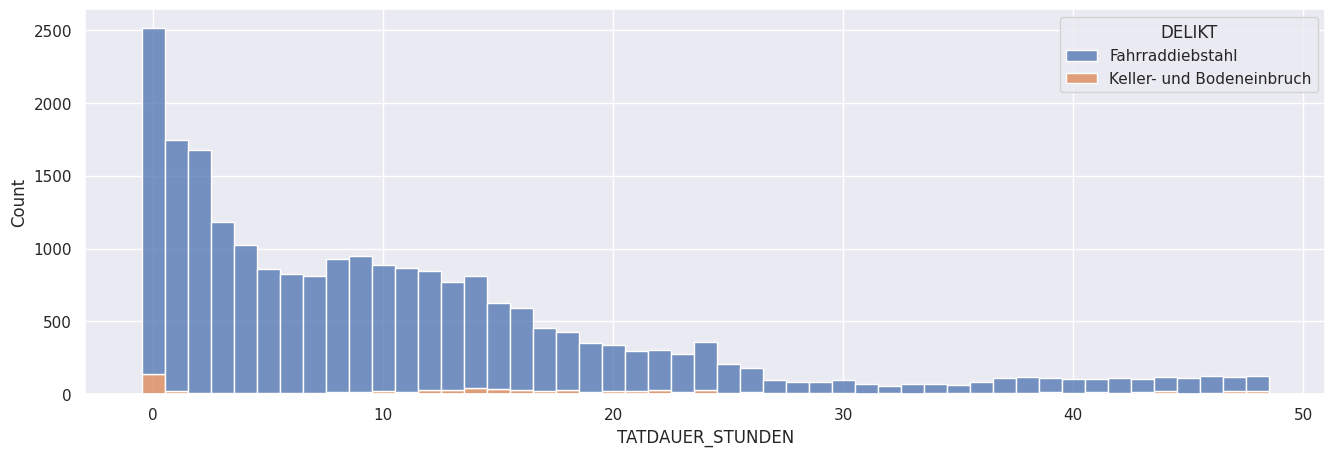

In [12]:
sns.histplot(
    data=merged_df,
    x="TATDAUER_STUNDEN",
    binrange=[0, 48],
    discrete=True,
    hue="DELIKT",
    multiple="stack",
)


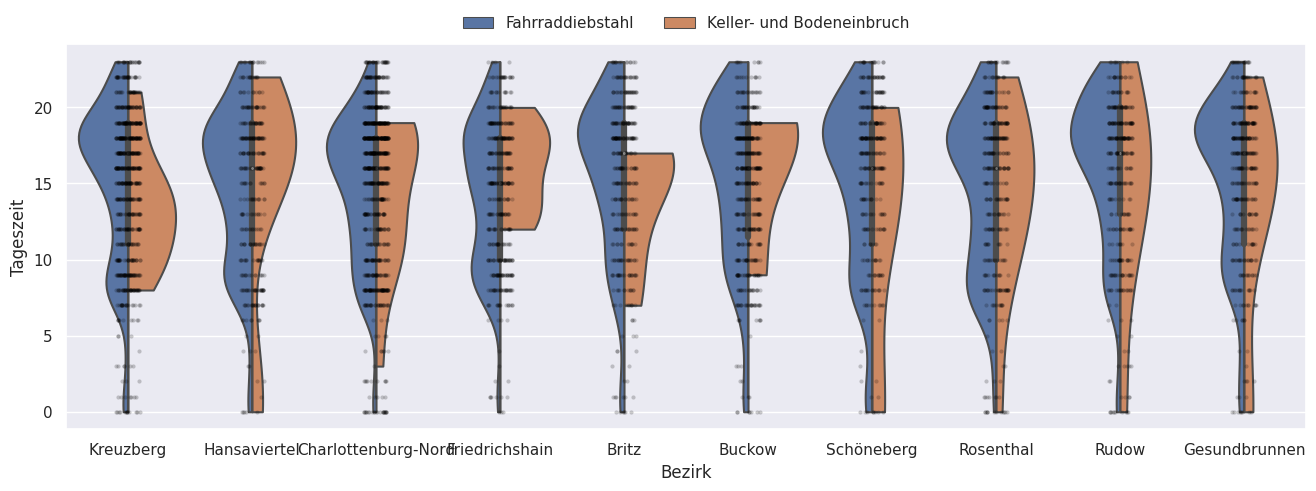

In [13]:
n_oteil = 10
top_oteil_crime_lst = (
    merged_df.groupby("OTEIL")
    .agg({"ANGELEGT_AM": "count"})
    .sort_values(by=("ANGELEGT_AM"), ascending=False)
    .head(n_oteil)
    .index.to_list()
)

plot_df = merged_df[merged_df.OTEIL.isin(top_oteil_crime_lst)]
fig, axes = plt.subplots()
sns.violinplot(
    x=plot_df.OTEIL,
    y=plot_df.TATZEIT_ANFANG_STUNDE,
    data_set=plot_df,
    ax=axes,
    order=top_oteil_crime_lst,
    cut=0,
    hue=plot_df.DELIKT,
    split=True,
    xlabel="BEZIRK",
)
sns.stripplot(
    data=plot_df,
    x=plot_df.OTEIL,
    y=plot_df.TATZEIT_ANFANG_STUNDE,
    size=3,
    color="black",
    alpha=0.2,
)

axes.yaxis.grid(True)
axes.set_xlabel("Bezirk")
axes.set_ylabel("Tageszeit")

sns.move_legend(
    axes,
    "lower center",
    bbox_to_anchor=(0.5, 1),
    ncol=2,
    title=None,
    frameon=False,
)


In [14]:
merged_df.groupby(["ART_DES_FAHRRADS"]).agg(
    {"ANGELEGT_AM": "count", "SCHADENSHOEHE": ["sum", "min", "max"]}
).sort_values(by=("ANGELEGT_AM", "count"), ascending=False).head(10)


ANGELEGT_AM SCHADENSHOEHE           
                        count           sum min    max
ART_DES_FAHRRADS                                      
Herrenfahrrad           11532      12579325   0   9900
Damenfahrrad             6639       6030777   0  10000
Fahrrad                  3405       4237608   0   9799
Mountainbike             1025        860735   0   8000
Kinderfahrrad             957        396804   0   1950
diverse Fahrräder         635       1263809   0  10000
Rennrad                   356        417124   0   8500
Lastenfahrrad              61        153369   0   9000

/tmp/ipykernel_45713/3248976659.py:2: UserWarning: The palette list has more values (20) than needed (12), which may not be intended.
  sns.histplot(


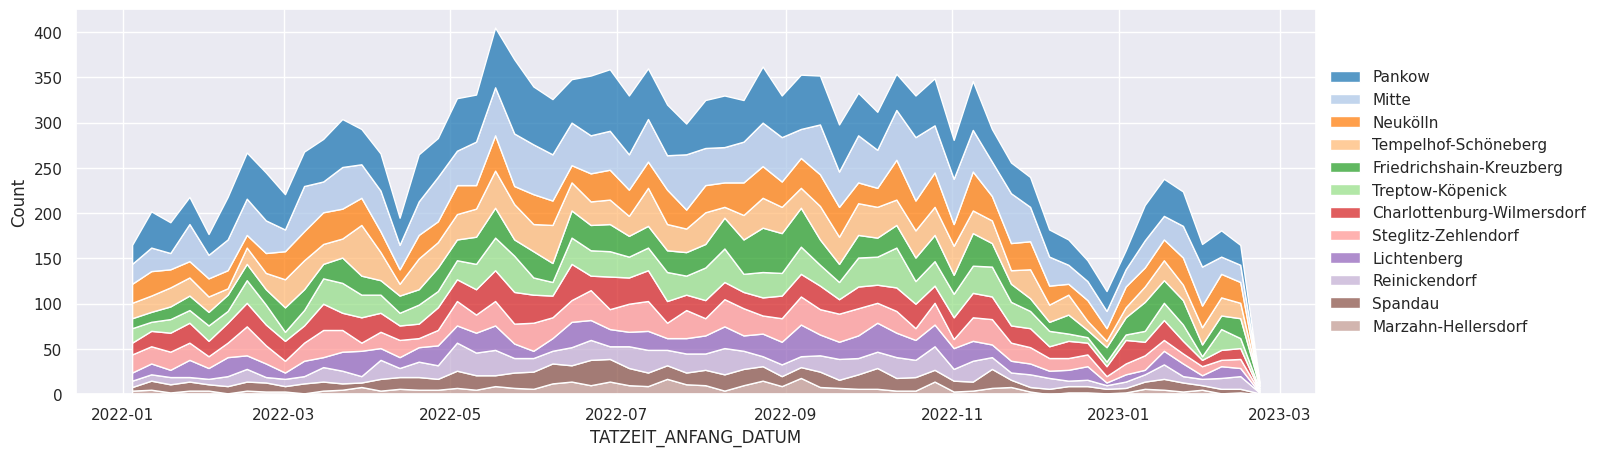

In [15]:
fig, ax = plt.subplots()
sns.histplot(
    ax=ax,
    data=merged_df,
    x="TATZEIT_ANFANG_DATUM",
    element="poly",
    hue="BEZIRK",
    hue_order=merged_df.groupby("BEZIRK")
    .agg({"LOR": "count"})
    .sort_values(by="LOR", ascending=False)
    .index.to_list(),
    multiple="stack",
    binwidth=7,
    palette=sns.color_palette("tab20"),
)
sns.move_legend(
    ax,
    "center left",
    bbox_to_anchor=(1, 0.5),
    title=None,
    frameon=False,
)
plt.show()


In [17]:
merged_df.groupby("VERSUCH").agg({"SCHADENSHOEHE":"sum"})

,SCHADENSHOEHE
VERSUCH,
Ja,0
Nein,25933481
Unbekannt,6070
